In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
from cnn_finetune import make_model

In [4]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 160

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(12345);

In [5]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        
    return predictions

In [12]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.RandomHorizontalFlip(), 
                                     transforms.RandomRotation([90, 180]),
                                     transforms.RandomVerticalFlip(), 
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

use_gpu = torch.cuda.is_available()

labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.1, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

batch_size = 256
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

criterion = nn.CrossEntropyLoss()

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()
    
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)   #for different input image size
criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.1567 Acc: 0.2717
val Loss: 2.8237 Acc: 0.1141
lr:  0.001

Epoch 1/29
----------
train Loss: 1.7924 Acc: 0.4146
val Loss: 2.1519 Acc: 0.2879
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6708 Acc: 0.4491
val Loss: 1.6657 Acc: 0.4931
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5714 Acc: 0.4745
val Loss: 1.6629 Acc: 0.4480
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4546 Acc: 0.5101
val Loss: 1.6070 Acc: 0.4664
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3783 Acc: 0.5502
val Loss: 2.5504 Acc: 0.3735
lr:  0.001

Epoch 6/29
----------
train Loss: 1.3117 Acc: 0.5688
val Loss: 1.6253 Acc: 0.5106
lr:  0.001

Epoch 7/29
----------
train Loss: 1.2269 Acc: 0.5950
val Loss: 2.0668 Acc: 0.4388
lr:  0.001

Epoch 8/29
----------
train Loss: 1.1705 Acc: 0.6167
val Loss: 1.7714 Acc: 0.5023
lr:  0.001

Epoch 9/29
----------
train Loss: 1.1041 Acc: 0.6401
val Loss: 2.3125 Acc: 0.4489
lr:  0.001

Epoch 10/29
----------
train Loss: 0.9423 Acc: 0.6979
val Lo

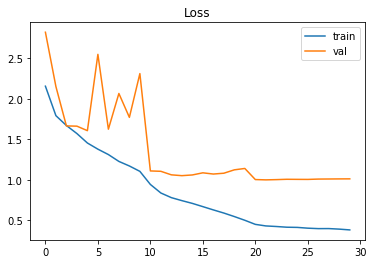

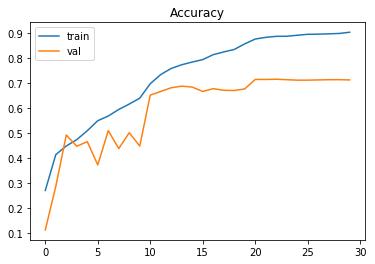

In [10]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1849 Acc: 0.2713
val Loss: 2.4620 Acc: 0.1076
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8394 Acc: 0.3889
val Loss: 2.3028 Acc: 0.2438
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6841 Acc: 0.4395
val Loss: 2.0268 Acc: 0.3137
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5699 Acc: 0.4738
val Loss: 1.8588 Acc: 0.4075
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4587 Acc: 0.5099
val Loss: 2.1821 Acc: 0.4094
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3371 Acc: 0.5582
val Loss: 1.4642 Acc: 0.4931
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2432 Acc: 0.5907
val Loss: 1.3221 Acc: 0.5639
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1909 Acc: 0.6190
val Loss: 1.2653 Acc: 0.5925
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.1485 Acc: 0.6316
val Loss: 1.2336 Acc: 0.6136
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.1046 Acc: 0.6417
val Loss: 1.2088 Acc: 0.6118
lr:  0.0001

Epoch 10/29
----------
train Loss: 1.0549 Acc: 0.6613
v

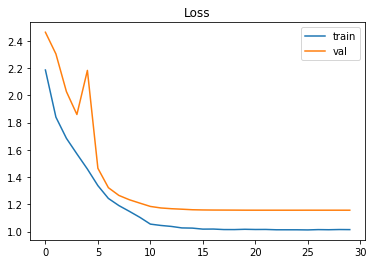

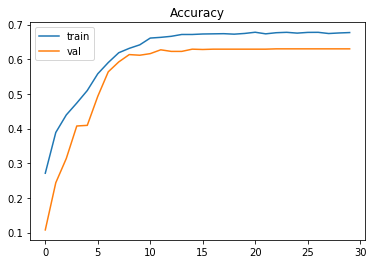

In [11]:
# resnet18, batch_size=256, Adam, step_size=5, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.4914 Acc: 0.1864
val Loss: 330.4398 Acc: 0.1582
lr:  0.01

Epoch 1/29
----------
train Loss: 2.0725 Acc: 0.3021
val Loss: 3.2516 Acc: 0.2116
lr:  0.01

Epoch 2/29
----------
train Loss: 1.9595 Acc: 0.3426
val Loss: 2.8399 Acc: 0.2291
lr:  0.01

Epoch 3/29
----------
train Loss: 1.9126 Acc: 0.3654
val Loss: 2.0751 Acc: 0.3100
lr:  0.01

Epoch 4/29
----------
train Loss: 1.8214 Acc: 0.3914
val Loss: 1.7942 Acc: 0.3956
lr:  0.01

Epoch 5/29
----------
train Loss: 1.7094 Acc: 0.4303
val Loss: 1.6840 Acc: 0.4361
lr:  0.001

Epoch 6/29
----------
train Loss: 1.6613 Acc: 0.4498
val Loss: 1.6556 Acc: 0.4416
lr:  0.001

Epoch 7/29
----------
train Loss: 1.6335 Acc: 0.4531
val Loss: 1.6459 Acc: 0.4563
lr:  0.001

Epoch 8/29
----------
train Loss: 1.6089 Acc: 0.4611
val Loss: 1.6401 Acc: 0.4545
lr:  0.001

Epoch 9/29
----------
train Loss: 1.5880 Acc: 0.4682
val Loss: 1.6292 Acc: 0.4526
lr:  0.001

Epoch 10/29
----------
train Loss: 1.5590 Acc: 0.4788
val Loss:

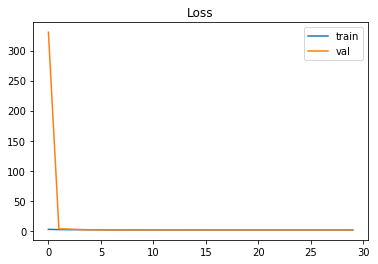

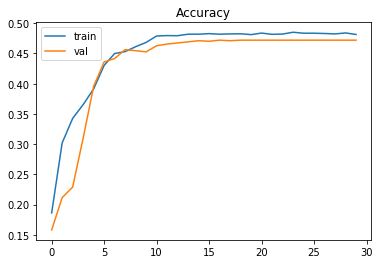

In [12]:
# resnet18, batch_size=256, Adam, step_size=5, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/19
----------
train Loss: 2.1252 Acc: 0.2849
val Loss: 2.4540 Acc: 0.1242
lr:  0.001

Epoch 1/19
----------
train Loss: 1.7946 Acc: 0.4093
val Loss: 2.1753 Acc: 0.2337
lr:  0.001

Epoch 2/19
----------
train Loss: 1.6576 Acc: 0.4441
val Loss: 2.1642 Acc: 0.3422
lr:  0.001

Epoch 3/19
----------
train Loss: 1.5431 Acc: 0.4871
val Loss: 1.6844 Acc: 0.4591
lr:  0.001

Epoch 4/19
----------
train Loss: 1.4441 Acc: 0.5205
val Loss: 1.8089 Acc: 0.4112
lr:  0.001

Epoch 5/19
----------
train Loss: 1.3565 Acc: 0.5527
val Loss: 1.4727 Acc: 0.5087
lr:  0.001

Epoch 6/19
----------
train Loss: 1.2802 Acc: 0.5817
val Loss: 2.3674 Acc: 0.3643
lr:  0.001

Epoch 7/19
----------
train Loss: 1.2398 Acc: 0.5936
val Loss: 2.3851 Acc: 0.3864
lr:  0.001

Epoch 8/19
----------
train Loss: 1.1621 Acc: 0.6213
val Loss: 1.5437 Acc: 0.4876
lr:  0.001

Epoch 9/19
----------
train Loss: 1.0445 Acc: 0.6583
val Loss: 1.3716 Acc: 0.5621
lr:  0.001

Epoch 10/19
----------
train Loss: 0.9489 Acc: 0.6917
val Lo

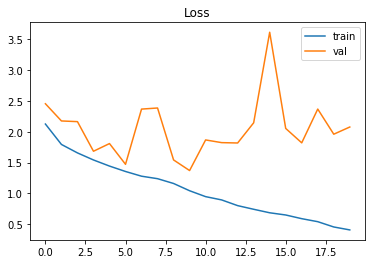

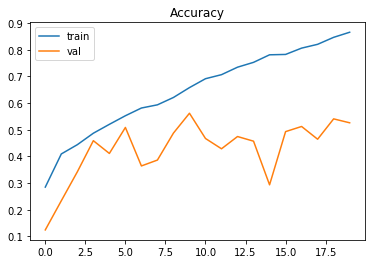

In [13]:
# resnet18, batch_size=256, Adam, step_size=20, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/9
----------
train Loss: 2.1346 Acc: 0.2936
val Loss: 2.5463 Acc: 0.0810
lr:  0.0001

Epoch 1/9
----------
train Loss: 1.6698 Acc: 0.4558
val Loss: 2.8412 Acc: 0.0506
lr:  0.0001

Epoch 2/9
----------
train Loss: 1.4163 Acc: 0.5481
val Loss: 2.1198 Acc: 0.2797
lr:  0.0001

Epoch 3/9
----------
train Loss: 1.1803 Acc: 0.6275
val Loss: 1.6552 Acc: 0.4701
lr:  0.0001

Epoch 4/9
----------
train Loss: 0.9378 Acc: 0.7234
val Loss: 1.4597 Acc: 0.5419
lr:  0.0001

Epoch 5/9
----------
train Loss: 0.7528 Acc: 0.7890
val Loss: 1.7603 Acc: 0.4370
lr:  0.0001

Epoch 6/9
----------
train Loss: 0.5871 Acc: 0.8497
val Loss: 1.6520 Acc: 0.4903
lr:  0.0001

Epoch 7/9
----------
train Loss: 0.4378 Acc: 0.9020
val Loss: 1.7708 Acc: 0.4876
lr:  0.0001

Epoch 8/9
----------
train Loss: 0.3309 Acc: 0.9340
val Loss: 1.6745 Acc: 0.5014
lr:  0.0001

Epoch 9/9
----------
train Loss: 0.2511 Acc: 0.9517
val Loss: 1.5932 Acc: 0.5198
lr:  0.0001

Training complete in 2m 37s
Best val Acc: 0.541858, epoch 4


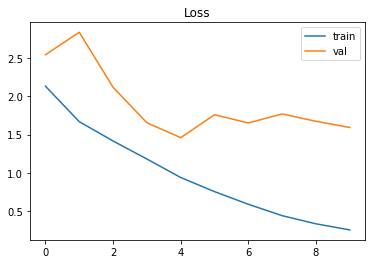

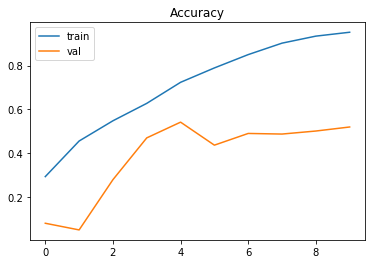

In [14]:
# resnet18, batch_size=256, Adam, step_size=20, num_epochs=10, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/29
----------
train Loss: 2.1423 Acc: 0.2841
val Loss: 2.7513 Acc: 0.0643
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8100 Acc: 0.4021
val Loss: 2.0546 Acc: 0.2739
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6726 Acc: 0.4453
val Loss: 1.7705 Acc: 0.4044
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5719 Acc: 0.4770
val Loss: 2.2381 Acc: 0.2647
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4759 Acc: 0.5116
val Loss: 1.6233 Acc: 0.4835
lr:  0.001

Epoch 5/29
----------
train Loss: 1.4012 Acc: 0.5384
val Loss: 2.3334 Acc: 0.3640
lr:  0.001

Epoch 6/29
----------
train Loss: 1.3030 Acc: 0.5719
val Loss: 1.4321 Acc: 0.5496
lr:  0.001

Epoch 7/29
----------
train Loss: 1.2393 Acc: 0.5942
val Loss: 2.0690 Acc: 0.4577
lr:  0.001

Epoch 8/29
----------
train Loss: 1.1573 Acc: 0.6234
val Loss: 1.4945 Acc: 0.4853
lr:  0.001

Epoch 9/29
----------
train Loss: 1.0831 Acc: 0.6482
val Loss: 1.4028 Acc: 0.5607
lr:  0.001

Epoch 10/29
----------
train Loss: 0.9579 Acc: 0.6846
val Lo

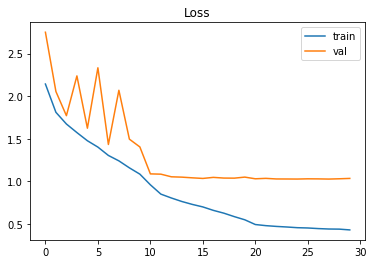

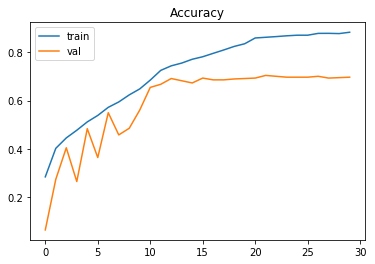

In [16]:
# val = 10%
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1577 Acc: 0.2724
val Loss: 2.4173 Acc: 0.1710
lr:  0.001

Epoch 1/29
----------
train Loss: 1.7782 Acc: 0.4144
val Loss: 2.2798 Acc: 0.2463
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6917 Acc: 0.4410
val Loss: 2.0194 Acc: 0.3456
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5820 Acc: 0.4782
val Loss: 2.1483 Acc: 0.3971
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4806 Acc: 0.5079
val Loss: 1.6235 Acc: 0.4669
lr:  0.001

Epoch 5/29
----------
train Loss: 1.4070 Acc: 0.5357
val Loss: 2.2110 Acc: 0.4081
lr:  0.001

Epoch 6/29
----------
train Loss: 1.3258 Acc: 0.5682
val Loss: 1.5213 Acc: 0.5000
lr:  0.001

Epoch 7/29
----------
train Loss: 1.2591 Acc: 0.5848
val Loss: 1.4757 Acc: 0.5147
lr:  0.001

Epoch 8/29
----------
train Loss: 1.2165 Acc: 0.5960
val Loss: 1.6764 Acc: 0.4173
lr:  0.001

Epoch 9/29
----------
train Loss: 1.1514 Acc: 0.6202
val Loss: 2.3691 Acc: 0.3621
lr:  0.001

Epoch 10/29
----------
train Loss: 1.0965 Acc: 0.6331
val Lo

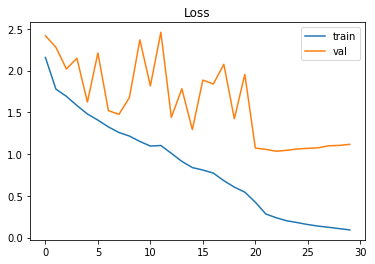

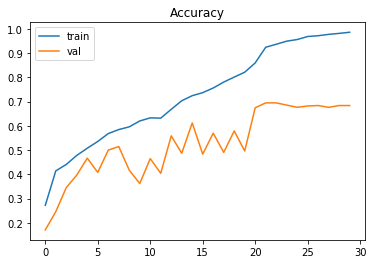

In [17]:
# val = 10%
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [5]:
model = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.5)
model.cuda();

Epoch 0/29
----------
train Loss: 2.1834 Acc: 0.2662
val Loss: 2.7013 Acc: 0.0368
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8345 Acc: 0.3985
val Loss: 1.9349 Acc: 0.3790
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7355 Acc: 0.4365
val Loss: 4.5988 Acc: 0.1812
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6219 Acc: 0.4673
val Loss: 1.8343 Acc: 0.4388
lr:  0.001

Epoch 4/29
----------
train Loss: 1.5009 Acc: 0.5053
val Loss: 1.6184 Acc: 0.4885
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3894 Acc: 0.5359
val Loss: 1.7213 Acc: 0.4471
lr:  0.001

Epoch 6/29
----------
train Loss: 1.3044 Acc: 0.5741
val Loss: 2.3323 Acc: 0.3671
lr:  0.001

Epoch 7/29
----------
train Loss: 1.2521 Acc: 0.5916
val Loss: 1.7355 Acc: 0.4775
lr:  0.001

Epoch 8/29
----------
train Loss: 1.1765 Acc: 0.6256
val Loss: 1.4071 Acc: 0.5391
lr:  0.001

Epoch 9/29
----------
train Loss: 1.1415 Acc: 0.6321
val Loss: 2.6711 Acc: 0.3873
lr:  0.001

Epoch 10/29
----------
train Loss: 0.9749 Acc: 0.6884
val Lo

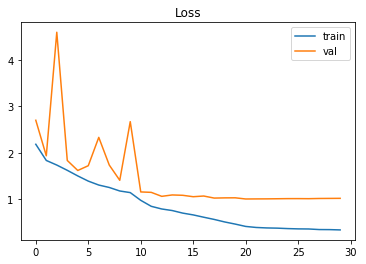

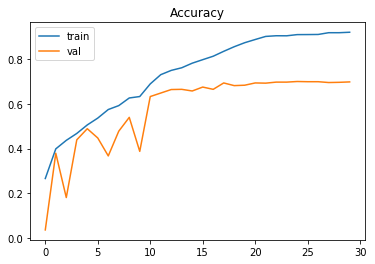

In [10]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/19
----------
train Loss: 2.1365 Acc: 0.2763
val Loss: 2.5359 Acc: 0.1067
lr:  0.001

Epoch 1/19
----------
train Loss: 1.8223 Acc: 0.4006
val Loss: 2.3414 Acc: 0.2420
lr:  0.001

Epoch 2/19
----------
train Loss: 1.7090 Acc: 0.4358
val Loss: 2.3834 Acc: 0.2603
lr:  0.001

Epoch 3/19
----------
train Loss: 1.5809 Acc: 0.4802
val Loss: 1.9612 Acc: 0.3376
lr:  0.001

Epoch 4/19
----------
train Loss: 1.4845 Acc: 0.5186
val Loss: 2.3554 Acc: 0.3220
lr:  0.001

Epoch 5/19
----------
train Loss: 1.4111 Acc: 0.5301
val Loss: 2.2131 Acc: 0.3183
lr:  0.001

Epoch 6/19
----------
train Loss: 1.3464 Acc: 0.5566
val Loss: 1.7432 Acc: 0.4949
lr:  0.001

Epoch 7/19
----------
train Loss: 1.2844 Acc: 0.5709
val Loss: 1.9557 Acc: 0.4443
lr:  0.001

Epoch 8/19
----------
train Loss: 1.2379 Acc: 0.5939
val Loss: 1.5470 Acc: 0.5244
lr:  0.001

Epoch 9/19
----------
train Loss: 1.1608 Acc: 0.6247
val Loss: 1.6759 Acc: 0.4876
lr:  0.001

Epoch 10/19
----------
train Loss: 1.0188 Acc: 0.6700
val Lo

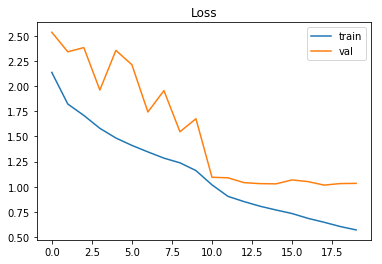

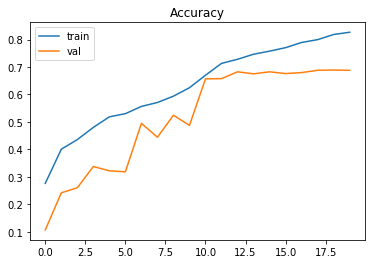

In [11]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.1842 Acc: 0.2575
val Loss: 2.4702 Acc: 0.0782
lr:  0.001

Epoch 1/19
----------
train Loss: 1.8019 Acc: 0.4075
val Loss: 2.1856 Acc: 0.2567
lr:  0.001

Epoch 2/19
----------
train Loss: 1.6427 Acc: 0.4577
val Loss: 2.0782 Acc: 0.2999
lr:  0.001

Epoch 3/19
----------
train Loss: 1.5566 Acc: 0.4841
val Loss: 1.6996 Acc: 0.4443
lr:  0.001

Epoch 4/19
----------
train Loss: 1.4521 Acc: 0.5274
val Loss: 3.6594 Acc: 0.3027
lr:  0.001

Epoch 5/19
----------
train Loss: 1.3812 Acc: 0.5439
val Loss: 1.5036 Acc: 0.5317
lr:  0.001

Epoch 6/19
----------
train Loss: 1.3330 Acc: 0.5649
val Loss: 1.9320 Acc: 0.4140
lr:  0.001

Epoch 7/19
----------
train Loss: 1.2384 Acc: 0.5955
val Loss: 1.6699 Acc: 0.4848
lr:  0.001

Epoch 8/19
----------
train Loss: 1.1530 Acc: 0.6279
val Loss: 1.6308 Acc: 0.4673
lr:  0.001

Epoch 9/19
----------
train Loss: 1.0741 Acc: 0.6530
val Loss: 1.8725 Acc: 0.4296
lr:  0.001

Epoch 10/19
----------
train Loss: 1.0436 Acc: 0.6590
val Lo

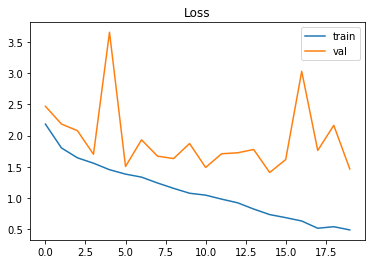

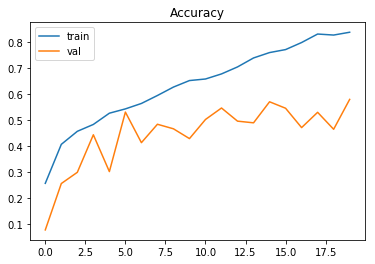

In [12]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.4988 Acc: 0.1949
val Loss: 1147.9237 Acc: 0.1398
lr:  0.01

Epoch 1/19
----------
train Loss: 2.1702 Acc: 0.2812
val Loss: 4.6704 Acc: 0.2337
lr:  0.01

Epoch 2/19
----------
train Loss: 2.0302 Acc: 0.3408
val Loss: 2.3275 Acc: 0.2916
lr:  0.01

Epoch 3/19
----------
train Loss: 1.9605 Acc: 0.3491
val Loss: 2.6437 Acc: 0.2557
lr:  0.01

Epoch 4/19
----------
train Loss: 1.8785 Acc: 0.3801
val Loss: 3.8390 Acc: 0.2134
lr:  0.01

Epoch 5/19
----------
train Loss: 1.8319 Acc: 0.3891
val Loss: 2.6486 Acc: 0.2539
lr:  0.01

Epoch 6/19
----------
train Loss: 1.7662 Acc: 0.4008
val Loss: 1.8094 Acc: 0.3735
lr:  0.01

Epoch 7/19
----------
train Loss: 1.6767 Acc: 0.4498
val Loss: 2.5237 Acc: 0.2429
lr:  0.01

Epoch 8/19
----------
train Loss: 1.6133 Acc: 0.4570
val Loss: 1.6457 Acc: 0.4692
lr:  0.01

Epoch 9/19
----------
train Loss: 1.5432 Acc: 0.4901
val Loss: 1.7709 Acc: 0.4029
lr:  0.01

Epoch 10/19
----------
train Loss: 1.4726 Acc: 0.5122
val Loss: 2.7

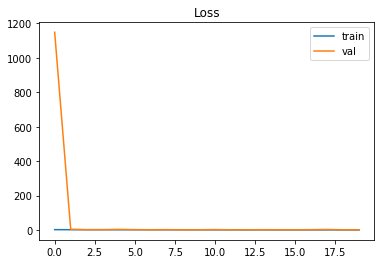

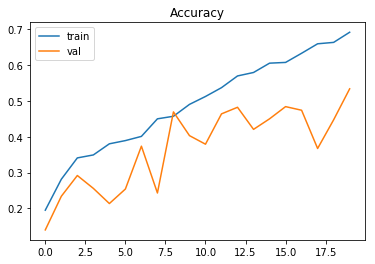

In [14]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.1789 Acc: 0.2628
val Loss: 2.5042 Acc: 0.0442
lr:  0.0001

Epoch 1/19
----------
train Loss: 1.7496 Acc: 0.4344
val Loss: 2.6027 Acc: 0.0478
lr:  0.0001

Epoch 2/19
----------
train Loss: 1.5271 Acc: 0.5092
val Loss: 1.9801 Acc: 0.3514
lr:  0.0001

Epoch 3/19
----------
train Loss: 1.3171 Acc: 0.5755
val Loss: 1.5606 Acc: 0.5051
lr:  0.0001

Epoch 4/19
----------
train Loss: 1.1049 Acc: 0.6613
val Loss: 1.6817 Acc: 0.4848
lr:  0.0001

Epoch 5/19
----------
train Loss: 0.8955 Acc: 0.7467
val Loss: 1.5171 Acc: 0.5299
lr:  0.0001

Epoch 6/19
----------
train Loss: 0.6935 Acc: 0.8164
val Loss: 1.5678 Acc: 0.5170
lr:  0.0001

Epoch 7/19
----------
train Loss: 0.5603 Acc: 0.8691
val Loss: 1.9087 Acc: 0.4351
lr:  0.0001

Epoch 8/19
----------
train Loss: 0.4419 Acc: 0.8992
val Loss: 1.5092 Acc: 0.5529
lr:  0.0001

Epoch 9/19
----------
train Loss: 0.3198 Acc: 0.9386
val Loss: 1.3809 Acc: 0.5943
lr:  0.0001

Epoch 10/19
----------
train Loss: 0.2481 Acc: 0.9

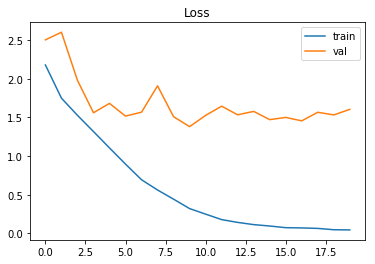

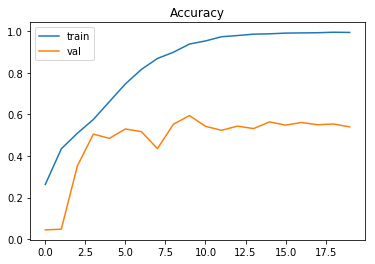

In [15]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, num_epochs=20)

Epoch 0/29
----------
train Loss: 2.2116 Acc: 0.2644
val Loss: 2.4263 Acc: 0.1279
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8488 Acc: 0.3951
val Loss: 2.1682 Acc: 0.2999
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7466 Acc: 0.4328
val Loss: 1.8278 Acc: 0.4361
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6036 Acc: 0.4788
val Loss: 1.6034 Acc: 0.4931
lr:  0.001

Epoch 4/29
----------
train Loss: 1.5159 Acc: 0.5030
val Loss: 1.7810 Acc: 0.4305
lr:  0.001

Epoch 5/29
----------
train Loss: 1.4219 Acc: 0.5315
val Loss: 1.4131 Acc: 0.5465
lr:  0.0005

Epoch 6/29
----------
train Loss: 1.3400 Acc: 0.5637
val Loss: 1.4528 Acc: 0.5511
lr:  0.0005

Epoch 7/29
----------
train Loss: 1.2613 Acc: 0.5849
val Loss: 1.4923 Acc: 0.5308
lr:  0.0005

Epoch 8/29
----------
train Loss: 1.1838 Acc: 0.6102
val Loss: 1.3131 Acc: 0.5934
lr:  0.0005

Epoch 9/29
----------
train Loss: 1.1070 Acc: 0.6413
val Loss: 1.5460 Acc: 0.5492
lr:  0.0005

Epoch 10/29
----------
train Loss: 0.9901 Acc: 0.6786
v

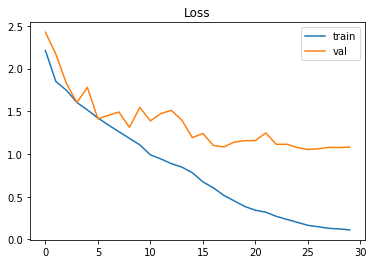

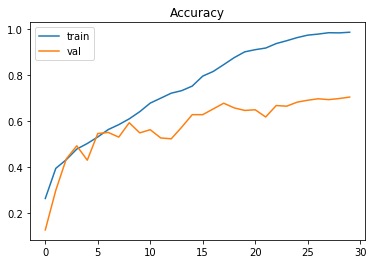

In [6]:
# resnet18, batch_size=256, Adam, step_size=5, num_epochs=30, lr=0.001, pretrained=True, dropout=0.5
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)
model.apply(reset)
model_rs18, loss_log, acc_log = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [7]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.7)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2291 Acc: 0.2474
val Loss: 2.4553 Acc: 0.1380
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8706 Acc: 0.3836
val Loss: 2.4389 Acc: 0.1904
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7245 Acc: 0.4372
val Loss: 2.1780 Acc: 0.2962
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5830 Acc: 0.4830
val Loss: 2.0312 Acc: 0.3634
lr:  0.001

Epoch 4/29
----------
train Loss: 1.5071 Acc: 0.5067
val Loss: 1.6360 Acc: 0.4618
lr:  0.001

Epoch 5/29
----------
train Loss: 1.4625 Acc: 0.5244
val Loss: 2.7953 Acc: 0.3560
lr:  0.001

Epoch 6/29
----------
train Loss: 1.4059 Acc: 0.5460
val Loss: 1.8049 Acc: 0.4508
lr:  0.001

Epoch 7/29
----------
train Loss: 1.3221 Acc: 0.5670
val Loss: 1.7073 Acc: 0.4949
lr:  0.001

Epoch 8/29
----------
train Loss: 1.2681 Acc: 0.5778
val Loss: 2.3596 Acc: 0.3726
lr:  0.001

Epoch 9/29
----------
train Loss: 1.1947 Acc: 0.6215
val Loss: 2.3989 Acc: 0.4140
lr:  0.001

Epoch 10/29
----------
train Loss: 1.0824 Acc: 0.6509
val Lo

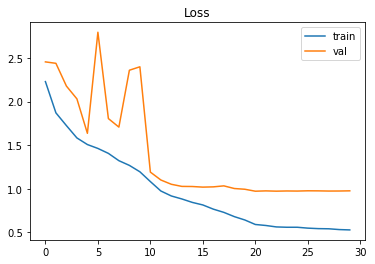

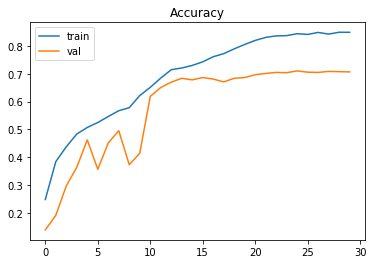

In [10]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True, dropout=0.7
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/14
----------
train Loss: 2.1655 Acc: 0.2701
val Loss: 2.5239 Acc: 0.0883
lr:  0.001

Epoch 1/14
----------
train Loss: 1.8816 Acc: 0.3688
val Loss: 2.1706 Acc: 0.2438
lr:  0.001

Epoch 2/14
----------
train Loss: 1.7240 Acc: 0.4328
val Loss: 1.8843 Acc: 0.3505
lr:  0.001

Epoch 3/14
----------
train Loss: 1.6236 Acc: 0.4740
val Loss: 1.7061 Acc: 0.4554
lr:  0.001

Epoch 4/14
----------
train Loss: 1.5432 Acc: 0.4913
val Loss: 1.5388 Acc: 0.4784
lr:  0.001

Epoch 5/14
----------
train Loss: 1.4459 Acc: 0.5295
val Loss: 1.6603 Acc: 0.4517
lr:  0.001

Epoch 6/14
----------
train Loss: 1.3717 Acc: 0.5552
val Loss: 1.5883 Acc: 0.5005
lr:  0.001

Epoch 7/14
----------
train Loss: 1.3247 Acc: 0.5699
val Loss: 1.6683 Acc: 0.4747
lr:  0.001

Epoch 8/14
----------
train Loss: 1.2479 Acc: 0.6001
val Loss: 1.5249 Acc: 0.5235
lr:  0.001

Epoch 9/14
----------
train Loss: 1.1624 Acc: 0.6289
val Loss: 1.2921 Acc: 0.5787
lr:  0.001

Epoch 10/14
----------
train Loss: 1.0664 Acc: 0.6615
val Lo

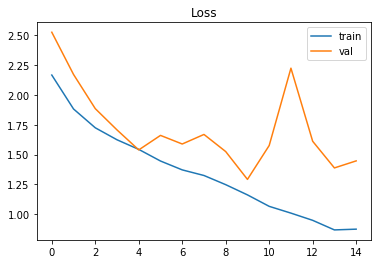

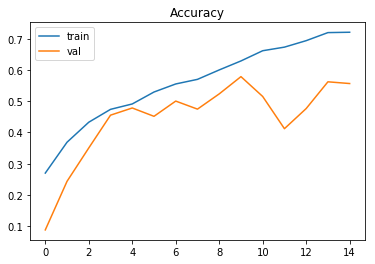

In [11]:
# resnet18, batch_size=64, Adam, lr_scheduler=None, num_epochs=15, lr=0.001, pretrained=True, dropout=0.7
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

In [12]:
torch.save(model_rs18, 'model_rs18')

Epoch 0/9
----------
train Loss: 1.4028 Acc: 0.5469
val Loss: 1.4612 Acc: 0.5143
lr:  0.001

Epoch 1/9
----------
train Loss: 1.1555 Acc: 0.6355
val Loss: 1.4284 Acc: 0.5520
lr:  0.001

Epoch 2/9
----------
train Loss: 1.0192 Acc: 0.6740
val Loss: 1.9528 Acc: 0.4931
lr:  0.001

Epoch 3/9
----------
train Loss: 0.9567 Acc: 0.6889
val Loss: 1.8635 Acc: 0.4572
lr:  0.001

Epoch 4/9
----------
train Loss: 0.9101 Acc: 0.7131
val Loss: 2.2551 Acc: 0.4223
lr:  0.001

Epoch 5/9
----------
train Loss: 0.8287 Acc: 0.7338
val Loss: 2.0178 Acc: 0.5106
lr:  0.001

Epoch 6/9
----------
train Loss: 0.7133 Acc: 0.7766
val Loss: 1.5177 Acc: 0.5437
lr:  0.001

Epoch 7/9
----------
train Loss: 0.6824 Acc: 0.7876
val Loss: 1.4500 Acc: 0.5934
lr:  0.001

Epoch 8/9
----------
train Loss: 0.6191 Acc: 0.8083
val Loss: 1.6748 Acc: 0.5704
lr:  0.001

Epoch 9/9
----------
train Loss: 0.5745 Acc: 0.8185
val Loss: 1.5019 Acc: 0.5428
lr:  0.001

Training complete in 2m 36s
Best val Acc: 0.593376, epoch 7


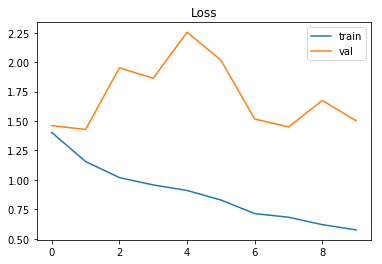

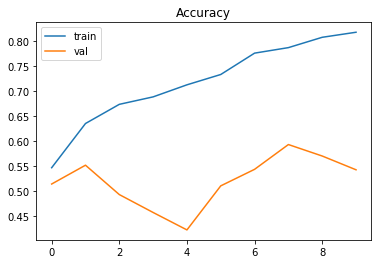

In [13]:
# resnet18, batch_size=64, Adam, lr_scheduler=None, num_epochs=15, lr=0.001, pretrained=True, dropout=0.7
optimizer_ft = optim.Adam(model_rs18.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)
model_rs18_2, loss_log, acc_log = train_model(model_rs18, criterion, optimizer_ft, num_epochs=10)

In [5]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.9)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.4051 Acc: 0.2073
val Loss: 2.3892 Acc: 0.1426
lr:  0.001

Epoch 1/29
----------
train Loss: 2.0466 Acc: 0.3178
val Loss: 2.1659 Acc: 0.2594
lr:  0.001

Epoch 2/29
----------
train Loss: 1.8878 Acc: 0.3902
val Loss: 1.8473 Acc: 0.3753
lr:  0.001

Epoch 3/29
----------
train Loss: 1.8193 Acc: 0.4126
val Loss: 1.7914 Acc: 0.4342
lr:  0.001

Epoch 4/29
----------
train Loss: 1.7228 Acc: 0.4381
val Loss: 1.9455 Acc: 0.4149
lr:  0.001

Epoch 5/29
----------
train Loss: 1.6659 Acc: 0.4676
val Loss: 1.7478 Acc: 0.4508
lr:  0.001

Epoch 6/29
----------
train Loss: 1.6096 Acc: 0.4747
val Loss: 2.1430 Acc: 0.3459
lr:  0.001

Epoch 7/29
----------
train Loss: 1.5689 Acc: 0.5005
val Loss: 1.6904 Acc: 0.4471
lr:  0.001

Epoch 8/29
----------
train Loss: 1.5267 Acc: 0.5094
val Loss: 2.6090 Acc: 0.3827
lr:  0.001

Epoch 9/29
----------
train Loss: 1.5025 Acc: 0.5094
val Loss: 2.2337 Acc: 0.3781
lr:  0.001

Epoch 10/29
----------
train Loss: 1.4142 Acc: 0.5504
val Lo

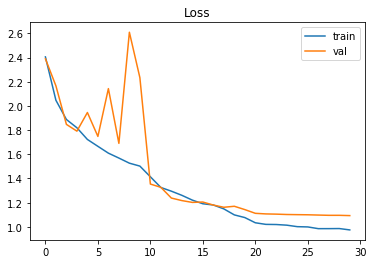

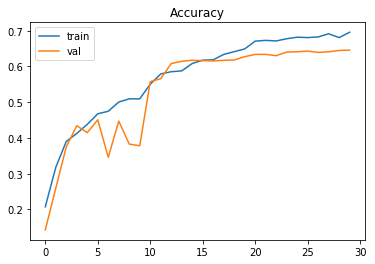

In [17]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/19
----------
train Loss: 2.4016 Acc: 0.2308
val Loss: 2.3893 Acc: 0.1279
lr:  0.001

Epoch 1/19
----------
train Loss: 2.0624 Acc: 0.3387
val Loss: 2.1746 Acc: 0.2879
lr:  0.001

Epoch 2/19
----------
train Loss: 1.8759 Acc: 0.3951
val Loss: 1.7592 Acc: 0.4342
lr:  0.001

Epoch 3/19
----------
train Loss: 1.7745 Acc: 0.4282
val Loss: 1.8452 Acc: 0.3799
lr:  0.001

Epoch 4/19
----------
train Loss: 1.7366 Acc: 0.4450
val Loss: 1.6101 Acc: 0.4968
lr:  0.001

Epoch 5/19
----------
train Loss: 1.6366 Acc: 0.4731
val Loss: 1.7651 Acc: 0.4315
lr:  0.001

Epoch 6/19
----------
train Loss: 1.5795 Acc: 0.4938
val Loss: 1.7895 Acc: 0.4388
lr:  0.001

Epoch 7/19
----------
train Loss: 1.5437 Acc: 0.5094
val Loss: 1.4488 Acc: 0.5317
lr:  0.001

Epoch 8/19
----------
train Loss: 1.4774 Acc: 0.5212
val Loss: 1.5217 Acc: 0.5225
lr:  0.001

Epoch 9/19
----------
train Loss: 1.5043 Acc: 0.5205
val Loss: 1.5780 Acc: 0.4738
lr:  0.001

Epoch 10/19
----------
train Loss: 1.3990 Acc: 0.5536
val Lo

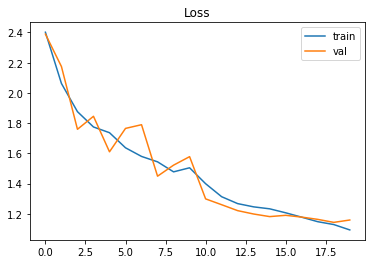

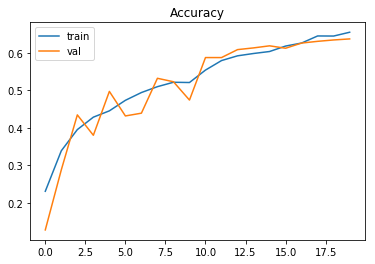

In [19]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.4369 Acc: 0.2000
val Loss: 2.3423 Acc: 0.1822
lr:  0.001

Epoch 1/19
----------
train Loss: 2.0252 Acc: 0.3470
val Loss: 2.0049 Acc: 0.3312
lr:  0.001

Epoch 2/19
----------
train Loss: 1.8789 Acc: 0.3958
val Loss: 2.1217 Acc: 0.2705
lr:  0.001

Epoch 3/19
----------
train Loss: 1.7956 Acc: 0.4195
val Loss: 1.7792 Acc: 0.3827
lr:  0.001

Epoch 4/19
----------
train Loss: 1.7080 Acc: 0.4584
val Loss: 2.3170 Acc: 0.3404
lr:  0.001

Epoch 5/19
----------
train Loss: 1.6321 Acc: 0.4830
val Loss: 1.6256 Acc: 0.4453
lr:  0.001

Epoch 6/19
----------
train Loss: 1.5610 Acc: 0.5002
val Loss: 1.5743 Acc: 0.4811
lr:  0.001

Epoch 7/19
----------
train Loss: 1.5116 Acc: 0.5168
val Loss: 1.6274 Acc: 0.4738
lr:  0.001

Epoch 8/19
----------
train Loss: 1.4503 Acc: 0.5334
val Loss: 1.5376 Acc: 0.4968
lr:  0.001

Epoch 9/19
----------
train Loss: 1.3975 Acc: 0.5458
val Loss: 1.5036 Acc: 0.4949
lr:  0.001

Epoch 10/19
----------
train Loss: 1.3281 Acc: 0.5803
val Lo

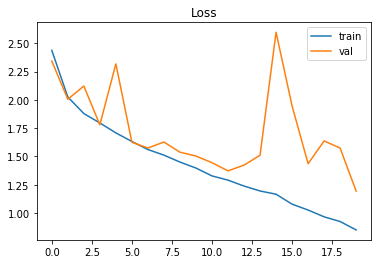

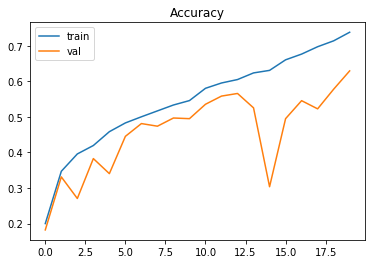

In [20]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

Epoch 0/9
----------
train Loss: 2.4717 Acc: 0.1988
val Loss: 2.3994 Acc: 0.1122
lr:  0.001

Epoch 1/9
----------
train Loss: 2.1283 Acc: 0.2853
val Loss: 2.2319 Acc: 0.2226
lr:  0.001

Epoch 2/9
----------
train Loss: 1.9368 Acc: 0.3619
val Loss: 2.0068 Acc: 0.3054
lr:  0.001

Epoch 3/9
----------
train Loss: 1.8169 Acc: 0.4144
val Loss: 1.9285 Acc: 0.3726
lr:  0.001

Epoch 4/9
----------
train Loss: 1.7789 Acc: 0.4248
val Loss: 1.7762 Acc: 0.3928
lr:  0.001

Epoch 5/9
----------
train Loss: 1.6943 Acc: 0.4535
val Loss: 1.6174 Acc: 0.4802
lr:  0.001

Epoch 6/9
----------
train Loss: 1.6370 Acc: 0.4788
val Loss: 1.8687 Acc: 0.3919
lr:  0.001

Epoch 7/9
----------
train Loss: 1.5884 Acc: 0.4940
val Loss: 1.6360 Acc: 0.4664
lr:  0.001

Epoch 8/9
----------
train Loss: 1.5421 Acc: 0.5009
val Loss: 1.6595 Acc: 0.4407
lr:  0.001

Epoch 9/9
----------
train Loss: 1.4714 Acc: 0.5249
val Loss: 1.5627 Acc: 0.5051
lr:  0.001

Training complete in 2m 39s
Best val Acc: 0.505060, epoch 9


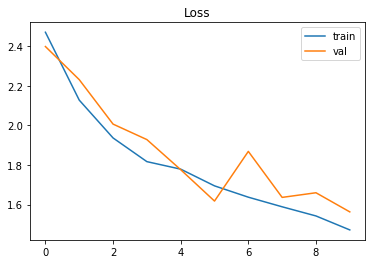

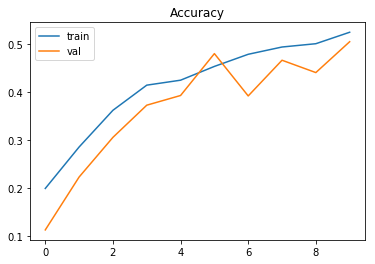

In [6]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

In [7]:
# save model, loss, acc
torch.save(model_rs18, 'model_rs18_1')
with open('loss_log_model_rs18_1.pkl', 'wb') as file:
    pickle.dump(loss_log, file, pickle.HIGHEST_PROTOCOL)
with open('acc_log_model_rs18_1.pkl', 'wb') as file:
    pickle.dump(acc_log, file, pickle.HIGHEST_PROTOCOL)    

In [7]:
# load model, loss, acc
model_rs18 = torch.load('log/model_rs18_1')

Epoch 0/9
----------
train Loss: 1.3611 Acc: 0.5640
val Loss: 1.2810 Acc: 0.5833
lr:  0.0001

Epoch 1/9
----------
train Loss: 1.3032 Acc: 0.5775
val Loss: 1.2403 Acc: 0.6017
lr:  0.0001

Epoch 2/9
----------
train Loss: 1.2663 Acc: 0.6008
val Loss: 1.1845 Acc: 0.6173
lr:  0.0001

Epoch 3/9
----------
train Loss: 1.2336 Acc: 0.6107
val Loss: 1.1816 Acc: 0.6219
lr:  0.0001

Epoch 4/9
----------
train Loss: 1.1881 Acc: 0.6215
val Loss: 1.1602 Acc: 0.6210
lr:  0.0001

Epoch 5/9
----------
train Loss: 1.1504 Acc: 0.6397
val Loss: 1.1457 Acc: 0.6339
lr:  0.0001

Epoch 6/9
----------
train Loss: 1.1201 Acc: 0.6447
val Loss: 1.1702 Acc: 0.6274
lr:  0.0001

Epoch 7/9
----------
train Loss: 1.0867 Acc: 0.6551
val Loss: 1.1223 Acc: 0.6394
lr:  0.0001

Epoch 8/9
----------
train Loss: 1.0466 Acc: 0.6786
val Loss: 1.1522 Acc: 0.6587
lr:  0.0001

Epoch 9/9
----------
train Loss: 1.0199 Acc: 0.6871
val Loss: 1.0975 Acc: 0.6578
lr:  0.0001

Training complete in 2m 38s
Best val Acc: 0.658694, epoch 8


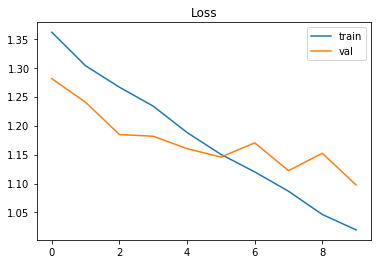

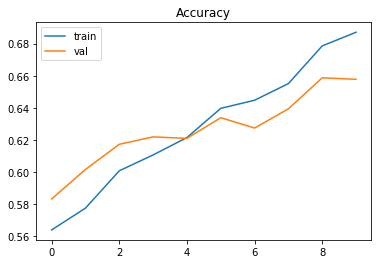

In [8]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18.parameters(), lr=0.0001)
model_rs18_2, loss_log_2, acc_log_2 = train_model(model_rs18, criterion, optimizer_ft, num_epochs=10)

In [9]:
# save model, loss, acc
torch.save(model_rs18_2, 'log/model_rs18_2')
with open('log/loss_log_model_rs18_2.pkl', 'wb') as file:
    pickle.dump(loss_log_2, file, pickle.HIGHEST_PROTOCOL)
with open('log/acc_log_model_rs18_2.pkl', 'wb') as file:
    pickle.dump(acc_log_2, file, pickle.HIGHEST_PROTOCOL)    

In [5]:
# load model
model_rs18_2 = torch.load('log/model_rs18_2')

Epoch 0/19
----------
train Loss: 1.0054 Acc: 0.6873
val Loss: 1.0715 Acc: 0.6569
lr:  1e-05

Epoch 1/19
----------
train Loss: 0.9765 Acc: 0.7011
val Loss: 1.0679 Acc: 0.6569
lr:  1e-05

Epoch 2/19
----------
train Loss: 0.9646 Acc: 0.7027
val Loss: 1.0658 Acc: 0.6587
lr:  1e-05

Epoch 3/19
----------
train Loss: 0.9813 Acc: 0.6997
val Loss: 1.0620 Acc: 0.6569
lr:  1e-05

Epoch 4/19
----------
train Loss: 0.9762 Acc: 0.7057
val Loss: 1.0605 Acc: 0.6596
lr:  1e-05

Epoch 5/19
----------
train Loss: 0.9568 Acc: 0.7055
val Loss: 1.0605 Acc: 0.6596
lr:  1e-05

Epoch 6/19
----------
train Loss: 0.9478 Acc: 0.7092
val Loss: 1.0611 Acc: 0.6550
lr:  1e-05

Epoch 7/19
----------
train Loss: 0.9511 Acc: 0.7066
val Loss: 1.0583 Acc: 0.6615
lr:  1e-05

Epoch 8/19
----------
train Loss: 0.9406 Acc: 0.7115
val Loss: 1.0580 Acc: 0.6587
lr:  1e-05

Epoch 9/19
----------
train Loss: 0.9321 Acc: 0.7115
val Loss: 1.0583 Acc: 0.6633
lr:  1e-05

Epoch 10/19
----------
train Loss: 0.9273 Acc: 0.7168
val Lo

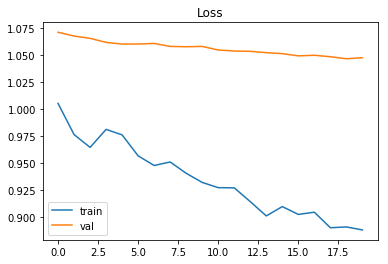

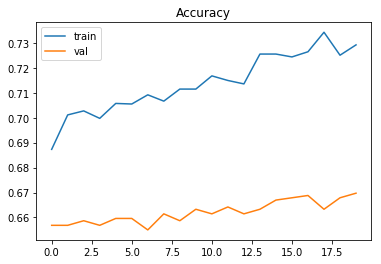

In [10]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18_2.parameters(), lr=0.00001)
model_rs18_3, loss_log_3, acc_log_3 = train_model(model_rs18_2, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0158 Acc: 0.6836
val Loss: 1.0898 Acc: 0.6587
lr:  5e-05

Epoch 1/19
----------
train Loss: 0.9791 Acc: 0.7020
val Loss: 1.0717 Acc: 0.6569
lr:  5e-05

Epoch 2/19
----------
train Loss: 0.9624 Acc: 0.7018
val Loss: 1.0862 Acc: 0.6495
lr:  5e-05

Epoch 3/19
----------
train Loss: 0.9335 Acc: 0.7149
val Loss: 1.0539 Acc: 0.6633
lr:  5e-05

Epoch 4/19
----------
train Loss: 0.9052 Acc: 0.7216
val Loss: 1.0503 Acc: 0.6624
lr:  5e-05

Epoch 5/19
----------
train Loss: 0.8790 Acc: 0.7358
val Loss: 1.0425 Acc: 0.6716
lr:  5e-05

Epoch 6/19
----------
train Loss: 0.8598 Acc: 0.7365
val Loss: 1.0549 Acc: 0.6679
lr:  5e-05

Epoch 7/19
----------
train Loss: 0.8381 Acc: 0.7540
val Loss: 1.0549 Acc: 0.6679
lr:  5e-05

Epoch 8/19
----------
train Loss: 0.8113 Acc: 0.7563
val Loss: 1.0365 Acc: 0.6725
lr:  5e-05

Epoch 9/19
----------
train Loss: 0.7912 Acc: 0.7646
val Loss: 1.0558 Acc: 0.6697
lr:  5e-05

Epoch 10/19
----------
train Loss: 0.7547 Acc: 0.7777
val Lo

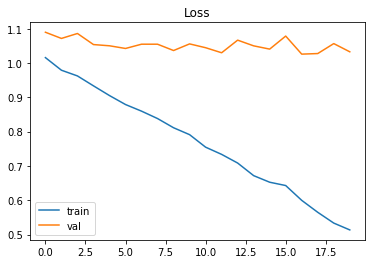

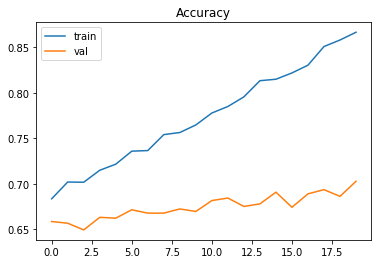

In [6]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18_2.parameters(), lr=0.00005)
model_rs18_3, loss_log_3, acc_log_3 = train_model(model_rs18_2, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5283 Acc: 0.8587
val Loss: 1.0788 Acc: 0.6881
lr:  5e-05

Epoch 1/19
----------
train Loss: 0.4813 Acc: 0.8714
val Loss: 1.0734 Acc: 0.6946
lr:  5e-05

Epoch 2/19
----------
train Loss: 0.4533 Acc: 0.8852
val Loss: 1.0817 Acc: 0.6854
lr:  5e-05

Epoch 3/19
----------
train Loss: 0.4260 Acc: 0.8921
val Loss: 1.0864 Acc: 0.6817
lr:  5e-05

Epoch 4/19
----------
train Loss: 0.4146 Acc: 0.8946
val Loss: 1.0964 Acc: 0.6753
lr:  5e-05

Epoch 5/19
----------
train Loss: 0.3876 Acc: 0.9050
val Loss: 1.0819 Acc: 0.6826
lr:  5e-05

Epoch 6/19
----------
train Loss: 0.3840 Acc: 0.9024
val Loss: 1.0642 Acc: 0.6900
lr:  5e-05

Epoch 7/19
----------
train Loss: 0.3508 Acc: 0.9176
val Loss: 1.0772 Acc: 0.6909
lr:  5e-05

Epoch 8/19
----------
train Loss: 0.3374 Acc: 0.9277
val Loss: 1.0723 Acc: 0.6955
lr:  5e-05

Epoch 9/19
----------
train Loss: 0.3248 Acc: 0.9287
val Loss: 1.0971 Acc: 0.6909
lr:  5e-05

Epoch 10/19
----------
train Loss: 0.3009 Acc: 0.9372
val Lo

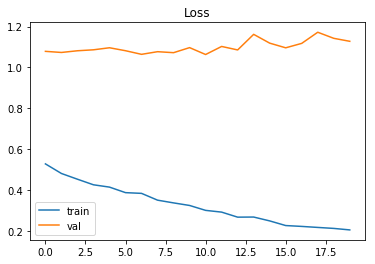

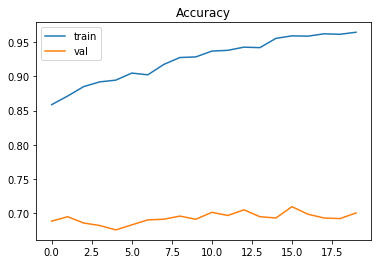

In [7]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18_2.parameters(), lr=0.00005)
model_rs18_3, loss_log_3, acc_log_3 = train_model(model_rs18_2, criterion, optimizer_ft, num_epochs=20)

Epoch 0/9
----------
train Loss: 0.2129 Acc: 0.9607
val Loss: 1.0652 Acc: 0.6973
lr:  1e-05

Epoch 1/9
----------
train Loss: 0.1996 Acc: 0.9659
val Loss: 1.0417 Acc: 0.7102
lr:  1e-05

Epoch 2/9
----------
train Loss: 0.1916 Acc: 0.9710
val Loss: 1.0610 Acc: 0.7084
lr:  1e-05

Epoch 3/9
----------
train Loss: 0.1900 Acc: 0.9682
val Loss: 1.0552 Acc: 0.7038
lr:  1e-05

Epoch 4/9
----------
train Loss: 0.1881 Acc: 0.9699
val Loss: 1.0654 Acc: 0.7084
lr:  1e-05

Epoch 5/9
----------
train Loss: 0.1755 Acc: 0.9740
val Loss: 1.0507 Acc: 0.7148
lr:  1e-05

Epoch 6/9
----------
train Loss: 0.1757 Acc: 0.9758
val Loss: 1.0636 Acc: 0.7084
lr:  1e-05

Epoch 7/9
----------
train Loss: 0.1727 Acc: 0.9763
val Loss: 1.0618 Acc: 0.7047
lr:  1e-05

Epoch 8/9
----------
train Loss: 0.1662 Acc: 0.9795
val Loss: 1.0711 Acc: 0.7001
lr:  1e-05

Epoch 9/9
----------
train Loss: 0.1649 Acc: 0.9784
val Loss: 1.0654 Acc: 0.7010
lr:  1e-05

Training complete in 2m 36s
Best val Acc: 0.714811, epoch 5


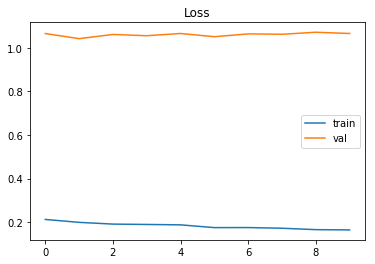

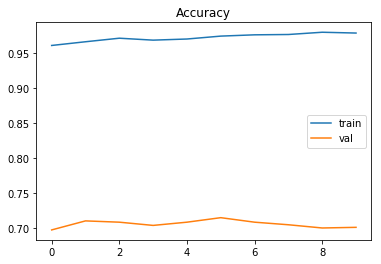

In [8]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18_2.parameters(), lr=0.00001)
model_rs18_3, loss_log_3, acc_log_3 = train_model(model_rs18_2, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1705 Acc: 0.9775
val Loss: 1.0526 Acc: 0.7121
lr:  1e-06

Epoch 1/9
----------
train Loss: 0.1704 Acc: 0.9779
val Loss: 1.0545 Acc: 0.7102
lr:  1e-06

Epoch 2/9
----------
train Loss: 0.1765 Acc: 0.9761
val Loss: 1.0554 Acc: 0.7111
lr:  1e-06

Epoch 3/9
----------
train Loss: 0.1676 Acc: 0.9784
val Loss: 1.0561 Acc: 0.7111
lr:  1e-06

Epoch 4/9
----------
train Loss: 0.1670 Acc: 0.9793
val Loss: 1.0557 Acc: 0.7093
lr:  1e-06

Epoch 5/9
----------
train Loss: 0.1698 Acc: 0.9781
val Loss: 1.0560 Acc: 0.7093
lr:  1e-06

Epoch 6/9
----------
train Loss: 0.1683 Acc: 0.9788
val Loss: 1.0569 Acc: 0.7084
lr:  1e-06

Epoch 7/9
----------
train Loss: 0.1710 Acc: 0.9770
val Loss: 1.0566 Acc: 0.7084
lr:  1e-06

Epoch 8/9
----------
train Loss: 0.1714 Acc: 0.9751
val Loss: 1.0573 Acc: 0.7084
lr:  1e-06

Epoch 9/9
----------
train Loss: 0.1723 Acc: 0.9779
val Loss: 1.0572 Acc: 0.7075
lr:  1e-06

Training complete in 2m 36s
Best val Acc: 0.712052, epoch 0


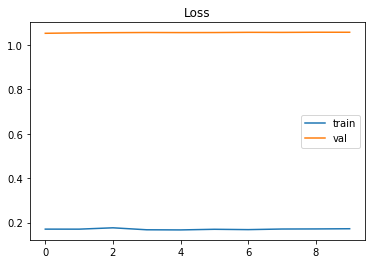

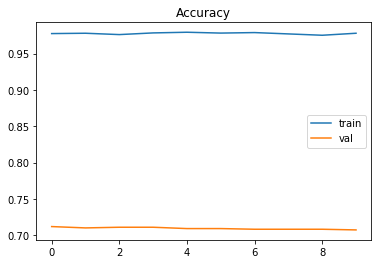

In [9]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=30, lr=0.0001, pretrained=True, dropout=0.9
optimizer_ft = optim.Adam(model_rs18_2.parameters(), lr=0.000001)
model_rs18_3, loss_log_3, acc_log_3 = train_model(model_rs18_2, criterion, optimizer_ft, num_epochs=10)

In [10]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.1486 Acc: 0.2782
val Loss: 2.5570 Acc: 0.0488
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8314 Acc: 0.3928
val Loss: 2.2533 Acc: 0.2852
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7015 Acc: 0.4399
val Loss: 1.9515 Acc: 0.3367
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5658 Acc: 0.4853
val Loss: 1.9772 Acc: 0.4048
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4448 Acc: 0.5272
val Loss: 1.6268 Acc: 0.4775
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3531 Acc: 0.5575
val Loss: 1.6238 Acc: 0.5069
lr:  0.001

Epoch 6/29
----------
train Loss: 1.2866 Acc: 0.5785
val Loss: 1.4088 Acc: 0.5465
lr:  0.001

Epoch 7/29
----------
train Loss: 1.1989 Acc: 0.6075
val Loss: 1.4712 Acc: 0.5437
lr:  0.001

Epoch 8/29
----------
train Loss: 1.1180 Acc: 0.6369
val Loss: 1.4212 Acc: 0.5492
lr:  0.001

Epoch 9/29
----------
train Loss: 1.0479 Acc: 0.6576
val Loss: 2.0768 Acc: 0.4609
lr:  0.001

Epoch 10/29
----------
train Loss: 0.9055 Acc: 0.7080
val Lo

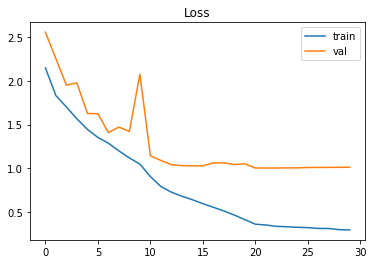

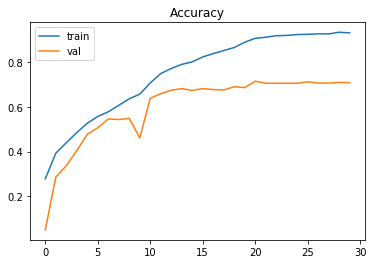

In [11]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [12]:
# save model, loss, acc
torch.save(model_rs18, 'log/model_rs18_1')
with open('log/loss_log_model_rs18_1.pkl', 'wb') as file:
    pickle.dump(loss_log, file, pickle.HIGHEST_PROTOCOL)
with open('log/acc_log_model_rs18_1.pkl', 'wb') as file:
    pickle.dump(acc_log, file, pickle.HIGHEST_PROTOCOL)    

In [15]:
# load model
model_rs18 = torch.load('log/model_rs18_1')

Epoch 0/9
----------
train Loss: 0.3496 Acc: 0.9123
val Loss: 0.9995 Acc: 0.7084
lr:  1e-06

Epoch 1/9
----------
train Loss: 0.3420 Acc: 0.9167
val Loss: 0.9993 Acc: 0.7111
lr:  1e-06

Epoch 2/9
----------
train Loss: 0.3423 Acc: 0.9135
val Loss: 0.9997 Acc: 0.7075
lr:  1e-06

Epoch 3/9
----------
train Loss: 0.3431 Acc: 0.9169
val Loss: 1.0000 Acc: 0.7084
lr:  1e-06

Epoch 4/9
----------
train Loss: 0.3412 Acc: 0.9176
val Loss: 1.0002 Acc: 0.7093
lr:  1e-06

Epoch 5/9
----------
train Loss: 0.3415 Acc: 0.9153
val Loss: 1.0005 Acc: 0.7093
lr:  1e-06

Epoch 6/9
----------
train Loss: 0.3429 Acc: 0.9167
val Loss: 1.0010 Acc: 0.7093
lr:  1e-06

Epoch 7/9
----------
train Loss: 0.3403 Acc: 0.9156
val Loss: 1.0011 Acc: 0.7084
lr:  1e-06

Epoch 8/9
----------
train Loss: 0.3366 Acc: 0.9190
val Loss: 1.0011 Acc: 0.7056
lr:  1e-06

Epoch 9/9
----------
train Loss: 0.3358 Acc: 0.9174
val Loss: 1.0016 Acc: 0.7056
lr:  1e-06

Training complete in 2m 36s
Best val Acc: 0.711132, epoch 1


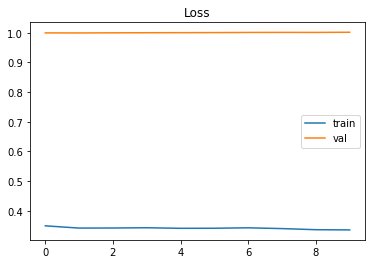

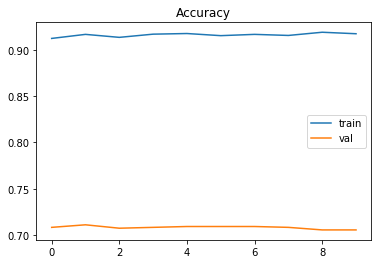

In [16]:
optimizer_ft = optim.Adam(model_rs18.parameters(), lr=0.000001)
model_rs18_2, loss_log, acc_log = train_model(model_rs18, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

In [22]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.6)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.1488 Acc: 0.2821
val Loss: 2.8324 Acc: 0.0764
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8343 Acc: 0.4043
val Loss: 2.5555 Acc: 0.1619
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7194 Acc: 0.4365
val Loss: 1.7880 Acc: 0.4075
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6030 Acc: 0.4793
val Loss: 1.9424 Acc: 0.3873
lr:  0.001

Epoch 4/29
----------
train Loss: 1.5280 Acc: 0.4956
val Loss: 1.7738 Acc: 0.4526
lr:  0.001

Epoch 5/29
----------
train Loss: 1.4646 Acc: 0.5179
val Loss: 2.3048 Acc: 0.3339
lr:  0.001

Epoch 6/29
----------
train Loss: 1.3905 Acc: 0.5495
val Loss: 2.4508 Acc: 0.3910
lr:  0.001

Epoch 7/29
----------
train Loss: 1.3351 Acc: 0.5647
val Loss: 1.7635 Acc: 0.4131
lr:  0.001

Epoch 8/29
----------
train Loss: 1.2461 Acc: 0.5976
val Loss: 2.0525 Acc: 0.3873
lr:  0.001

Epoch 9/29
----------
train Loss: 1.1840 Acc: 0.6171
val Loss: 4.3636 Acc: 0.3054
lr:  0.001

Epoch 10/29
----------
train Loss: 1.0461 Acc: 0.6684
val Lo

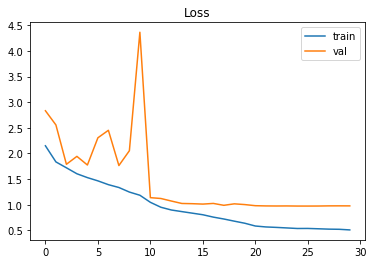

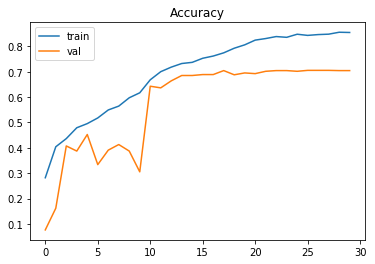

In [18]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/39
----------
train Loss: 2.6169 Acc: 0.1569
val Loss: 2241.8962 Acc: 0.1279
lr:  0.01

Epoch 1/39
----------
train Loss: 2.3220 Acc: 0.2138
val Loss: 12.6218 Acc: 0.1325
lr:  0.01

Epoch 2/39
----------
train Loss: 2.1768 Acc: 0.2798
val Loss: 2.5808 Acc: 0.2070
lr:  0.01

Epoch 3/39
----------
train Loss: 2.0303 Acc: 0.3293
val Loss: 1.9835 Acc: 0.3330
lr:  0.01

Epoch 4/39
----------
train Loss: 1.9491 Acc: 0.3576
val Loss: 2.0110 Acc: 0.3450
lr:  0.01

Epoch 5/39
----------
train Loss: 1.8632 Acc: 0.3831
val Loss: 2.5490 Acc: 0.2962
lr:  0.01

Epoch 6/39
----------
train Loss: 1.8168 Acc: 0.4089
val Loss: 2.1291 Acc: 0.2686
lr:  0.01

Epoch 7/39
----------
train Loss: 1.7650 Acc: 0.4289
val Loss: 2.2034 Acc: 0.3165
lr:  0.01

Epoch 8/39
----------
train Loss: 1.7272 Acc: 0.4399
val Loss: 2.0470 Acc: 0.3726
lr:  0.01

Epoch 9/39
----------
train Loss: 1.6696 Acc: 0.4538
val Loss: 1.8171 Acc: 0.3974
lr:  0.01

Epoch 10/39
----------
train Loss: 1.5780 Acc: 0.4901
val Loss: 1.

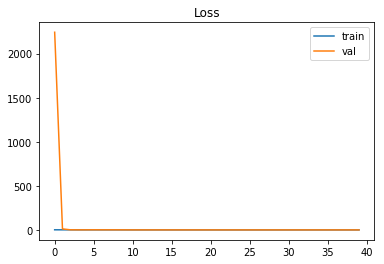

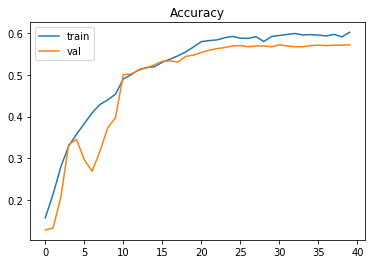

In [23]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/29
----------
train Loss: 2.2314 Acc: 0.2487
val Loss: 2.5174 Acc: 0.0764
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8702 Acc: 0.3962
val Loss: 2.7845 Acc: 0.0892
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6354 Acc: 0.4703
val Loss: 1.9090 Acc: 0.3956
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.4706 Acc: 0.5235
val Loss: 1.6282 Acc: 0.4922
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.2960 Acc: 0.5805
val Loss: 1.5580 Acc: 0.4959
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.1069 Acc: 0.6652
val Loss: 1.6961 Acc: 0.4499
lr:  0.0001

Epoch 6/29
----------
train Loss: 0.9418 Acc: 0.7239
val Loss: 1.4970 Acc: 0.5290
lr:  0.0001

Epoch 7/29
----------
train Loss: 0.7262 Acc: 0.8017
val Loss: 1.7008 Acc: 0.4719
lr:  0.0001

Epoch 8/29
----------
train Loss: 0.5726 Acc: 0.8617
val Loss: 1.5032 Acc: 0.5317
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.4559 Acc: 0.8948
val Loss: 1.4358 Acc: 0.5455
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.3114 Acc: 0.9

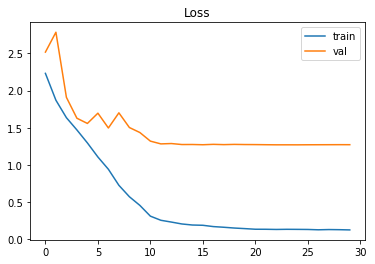

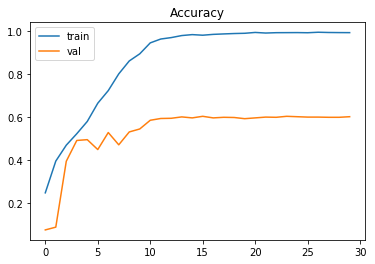

In [24]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [19]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.8)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2560 Acc: 0.2478
val Loss: 2.6181 Acc: 0.0837
lr:  0.001

Epoch 1/29
----------
train Loss: 1.9417 Acc: 0.3606
val Loss: 2.0632 Acc: 0.2925
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7892 Acc: 0.4137
val Loss: 2.0411 Acc: 0.3367
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6895 Acc: 0.4416
val Loss: 1.8134 Acc: 0.3965
lr:  0.001

Epoch 4/29
----------
train Loss: 1.6143 Acc: 0.4811
val Loss: 2.6376 Acc: 0.3293
lr:  0.001

Epoch 5/29
----------
train Loss: 1.5578 Acc: 0.4998
val Loss: 1.6311 Acc: 0.4811
lr:  0.001

Epoch 6/29
----------
train Loss: 1.4709 Acc: 0.5237
val Loss: 2.0905 Acc: 0.4075
lr:  0.001

Epoch 7/29
----------
train Loss: 1.3820 Acc: 0.5617
val Loss: 1.7875 Acc: 0.4554
lr:  0.001

Epoch 8/29
----------
train Loss: 1.3077 Acc: 0.5787
val Loss: 1.8311 Acc: 0.4673
lr:  0.001

Epoch 9/29
----------
train Loss: 1.2687 Acc: 0.5904
val Loss: 3.0754 Acc: 0.3864
lr:  0.001

Epoch 10/29
----------
train Loss: 1.1757 Acc: 0.6302
val Lo

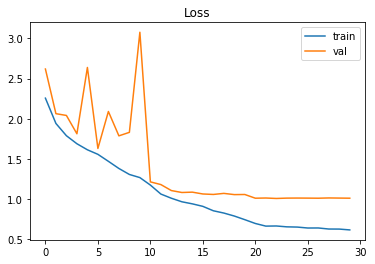

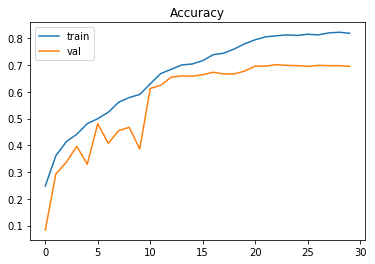

In [20]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [25]:
model_ft = make_model('resnet18', num_classes=12, pretrained=True, dropout_p=0.1)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.1258 Acc: 0.2819
val Loss: 2.5339 Acc: 0.0745
lr:  0.001

Epoch 1/29
----------
train Loss: 1.7852 Acc: 0.4075
val Loss: 2.2660 Acc: 0.2806
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6614 Acc: 0.4457
val Loss: 1.7571 Acc: 0.3937
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5684 Acc: 0.4765
val Loss: 2.0005 Acc: 0.3855
lr:  0.001

Epoch 4/29
----------
train Loss: 1.4898 Acc: 0.5133
val Loss: 1.5695 Acc: 0.5032
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3949 Acc: 0.5430
val Loss: 1.8928 Acc: 0.4434
lr:  0.001

Epoch 6/29
----------
train Loss: 1.2958 Acc: 0.5681
val Loss: 2.9237 Acc: 0.3431
lr:  0.001

Epoch 7/29
----------
train Loss: 1.2211 Acc: 0.6029
val Loss: 1.5167 Acc: 0.5409
lr:  0.001

Epoch 8/29
----------
train Loss: 1.1587 Acc: 0.6259
val Loss: 2.4705 Acc: 0.4443
lr:  0.001

Epoch 9/29
----------
train Loss: 1.0834 Acc: 0.6408
val Loss: 1.6421 Acc: 0.5060
lr:  0.001

Epoch 10/29
----------
train Loss: 0.9523 Acc: 0.6894
val Lo

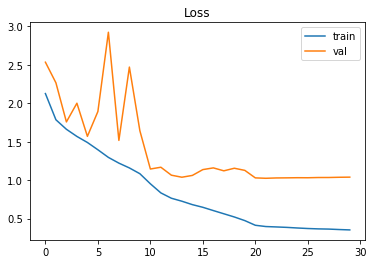

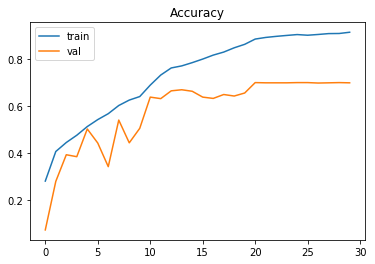

In [26]:
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [27]:
model_ft = make_model('resnet34', num_classes=12, pretrained=True)
model_ft.cuda();

In [ ]:
# resnet34, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1214 Acc: 0.2790
val Loss: 2.7025 Acc: 0.0772
lr:  0.001

Epoch 1/29
----------
train Loss: 1.7973 Acc: 0.4036
val Loss: 2.2847 Acc: 0.2022
lr:  0.001

Epoch 2/29
----------
train Loss: 1.6493 Acc: 0.4596
val Loss: 1.9424 Acc: 0.3897
lr:  0.001

Epoch 3/29
----------
train Loss: 1.5077 Acc: 0.5047
val Loss: 1.5813 Acc: 0.4669
lr:  0.001

Epoch 4/29
----------
train Loss: 1.3891 Acc: 0.5450
val Loss: 1.7164 Acc: 0.4816
lr:  0.001

Epoch 5/29
----------
train Loss: 1.3021 Acc: 0.5728
val Loss: 1.6359 Acc: 0.4559
lr:  0.001

Epoch 6/29
----------
train Loss: 1.2245 Acc: 0.5954
val Loss: 1.8397 Acc: 0.4779
lr:  0.001

Epoch 7/29
----------
train Loss: 1.1445 Acc: 0.6262
val Loss: 1.9417 Acc: 0.4816
lr:  0.001

Epoch 8/29
----------
train Loss: 1.0688 Acc: 0.6536
val Loss: 2.4733 Acc: 0.3750
lr:  0.001

Epoch 9/29
----------
train Loss: 1.0057 Acc: 0.6727
val Loss: 1.8546 Acc: 0.4375
lr:  0.001

Epoch 10/29
----------
train Loss: 0.8257 Acc: 0.7353
val Lo

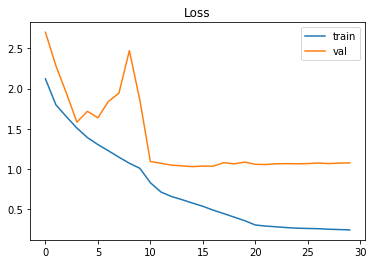

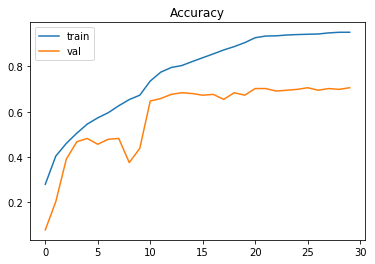

In [9]:
# val = 5%
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1467 Acc: 0.2751
val Loss: 2.3773 Acc: 0.2040
lr:  0.001

Epoch 1/29
----------
train Loss: 1.8228 Acc: 0.3862
val Loss: 2.1451 Acc: 0.2629
lr:  0.001

Epoch 2/29
----------
train Loss: 1.7205 Acc: 0.4263
val Loss: 2.0020 Acc: 0.2960
lr:  0.001

Epoch 3/29
----------
train Loss: 1.6979 Acc: 0.4365
val Loss: 1.9226 Acc: 0.3529
lr:  0.001

Epoch 4/29
----------
train Loss: 1.5566 Acc: 0.4856
val Loss: 2.0064 Acc: 0.3511
lr:  0.001

Epoch 5/29
----------
train Loss: 1.5600 Acc: 0.4954
val Loss: 1.9058 Acc: 0.4173
lr:  0.001

Epoch 6/29
----------
train Loss: 1.4996 Acc: 0.5052
val Loss: 1.5783 Acc: 0.4871
lr:  0.001

Epoch 7/29
----------
train Loss: 1.4446 Acc: 0.5265
val Loss: 1.5952 Acc: 0.4871
lr:  0.001

Epoch 8/29
----------
train Loss: 1.4033 Acc: 0.5402
val Loss: 1.5493 Acc: 0.4835
lr:  0.001

Epoch 9/29
----------
train Loss: 1.3656 Acc: 0.5531
val Loss: 1.7321 Acc: 0.4062
lr:  0.001

Epoch 10/29
----------
train Loss: 1.2813 Acc: 0.5752
val Lo

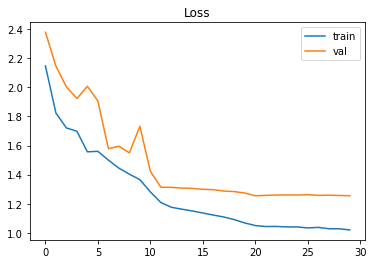

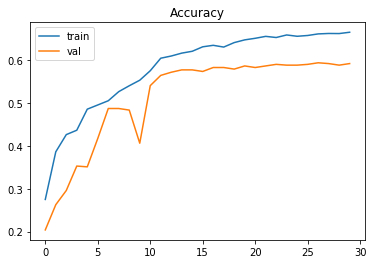

In [13]:
# val = 10% more transforms
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/9
----------
train Loss: 2.1833 Acc: 0.2632
val Loss: 2.5033 Acc: 0.0754
lr:  0.0001

Epoch 1/9
----------
train Loss: 1.8109 Acc: 0.3989
val Loss: 2.1281 Acc: 0.2279
lr:  0.0001

Epoch 2/9
----------
train Loss: 1.6721 Acc: 0.4516
val Loss: 1.6153 Acc: 0.4761
lr:  0.0001

Epoch 3/9
----------
train Loss: 1.5776 Acc: 0.4841
val Loss: 1.7921 Acc: 0.4099
lr:  0.0001

Epoch 4/9
----------
train Loss: 1.4893 Acc: 0.5138
val Loss: 1.5741 Acc: 0.4926
lr:  0.0001

Epoch 5/9
----------
train Loss: 1.4255 Acc: 0.5287
val Loss: 1.7018 Acc: 0.4504
lr:  0.0001

Epoch 6/9
----------
train Loss: 1.3605 Acc: 0.5533
val Loss: 1.4565 Acc: 0.5423
lr:  0.0001

Epoch 7/9
----------
train Loss: 1.3090 Acc: 0.5741
val Loss: 1.4345 Acc: 0.5368
lr:  0.0001

Epoch 8/9
----------
train Loss: 1.2616 Acc: 0.5964
val Loss: 1.4508 Acc: 0.5276
lr:  0.0001

Epoch 9/9
----------
train Loss: 1.2507 Acc: 0.5926
val Loss: 1.4121 Acc: 0.5423
lr:  0.0001

Training complete in 2m 45s
Best val Acc: 0.542279, epoch 6


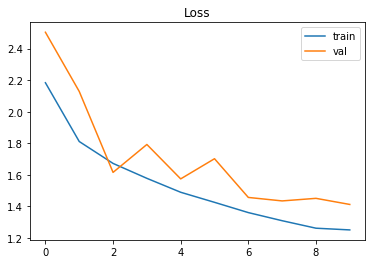

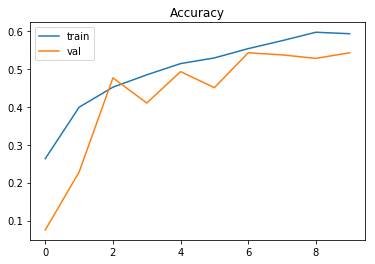

In [18]:
# val = 10% more transforms
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

In [19]:
torch.save(model_rs18, 'model_rs18')

Epoch 0/9
----------
train Loss: 1.2578 Acc: 0.5864
val Loss: 1.3718 Acc: 0.5570
lr:  1e-05

Epoch 1/9
----------
train Loss: 1.2352 Acc: 0.5962
val Loss: 1.3756 Acc: 0.5533
lr:  1e-05

Epoch 2/9
----------
train Loss: 1.2098 Acc: 0.5987
val Loss: 1.3697 Acc: 0.5625
lr:  1e-05

Epoch 3/9
----------
train Loss: 1.2031 Acc: 0.6108
val Loss: 1.3618 Acc: 0.5625
lr:  1e-05

Epoch 4/9
----------
train Loss: 1.1944 Acc: 0.6069
val Loss: 1.3581 Acc: 0.5643
lr:  1e-05

Epoch 5/9
----------
train Loss: 1.1814 Acc: 0.6106
val Loss: 1.3523 Acc: 0.5625
lr:  1e-05

Epoch 6/9
----------
train Loss: 1.1698 Acc: 0.6243
val Loss: 1.3514 Acc: 0.5570
lr:  1e-05

Epoch 7/9
----------
train Loss: 1.1645 Acc: 0.6175
val Loss: 1.3547 Acc: 0.5643
lr:  1e-05

Epoch 8/9
----------
train Loss: 1.1545 Acc: 0.6292
val Loss: 1.3504 Acc: 0.5662
lr:  1e-05

Epoch 9/9
----------
train Loss: 1.1414 Acc: 0.6302
val Loss: 1.3419 Acc: 0.5588
lr:  1e-05

Training complete in 2m 46s
Best val Acc: 0.566176, epoch 8


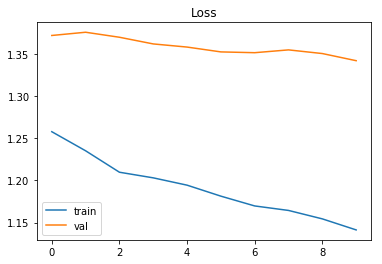

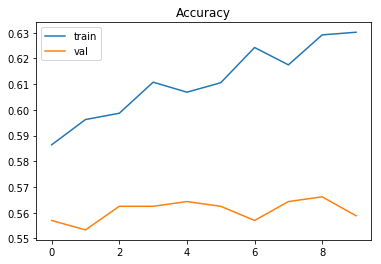

In [20]:
# val = 10% more transforms
# resnet18, batch_size=64, Adam, lr_scheduler, num_epochs=17, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)
model_rs18, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)